# Setup

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhishekinnvonix/seizure-epilepcy-chb-mit-eeg-dataset-pediatric")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric


In [2]:
import re

import mne
import numpy as np

from pathlib import Path
from typing import List, Tuple

import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
ROOT = Path('/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0')

# Data Exploration

In [4]:
sample_raw_file = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf'
raw = mne.io.read_raw_edf(sample_raw_file, preload=True)

Extracting EDF parameters from /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_23/209497664.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(sample_raw_file, preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


In [5]:
SAMPLING_RATE = raw.info['sfreq']
SAMPLING_RATE

256.0

# Extract every seizure periods

In [6]:
import re

# Function to parse the text file
def parse_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Regular expression patterns for extracting information
    file_pattern = r"File Name: (.+)\nFile Start Time: (.+)\nFile End Time: (.+)\nNumber of Seizures in File: (\d+)"
    seizure_pattern = r"Seizure \d+ Start Time: (\d+) seconds\nSeizure \d+ End Time: (\d+) seconds"
    
    # Split content into blocks for each file
    file_blocks = content.split("\n\n")
    data = []
    
    for block in file_blocks:
        file_info_match = re.search(file_pattern, block)
        if file_info_match:
            file_info = {
                "File Name": file_info_match.group(1),
                "Start Time": file_info_match.group(2),
                "End Time": file_info_match.group(3),
                "Number of Seizures": int(file_info_match.group(4)),
                "Seizures": []
            }
            # If there are seizures, find their start and end times
            if file_info["Number of Seizures"] > 0:
                seizures = re.findall(seizure_pattern, block)
                file_info["Seizures"] = [{"Start Time": int(start), "End Time": int(end)} for start, end in seizures]
            data.append(file_info)
    
    return data


In [7]:
def get_summary(folder):
    folder_name = folder.name
    summary_file = f'{folder_name}-summary.txt'
    summary_info = parse_file(folder / summary_file)
    return summary_info
    

# Data preprocessing


In [8]:
from collections import defaultdict

def get_preictal_regions(id, seizures):
    preictal_duration = 30 * 60
    preictal_regions = defaultdict(list)
    for seizure in seizures:
        onset = seizure['Start Time']
        preictal_regions[id].append((np.max([onset - preictal_duration, 0]), onset))
        if onset - preictal_duration < 0:
            preictal_regions[id - 1].append((onset - preictal_duration, -1))
    return preictal_regions

In [9]:
def process_signal(raw, preictals):
    epoch_duration = 5
    raw_data = raw.get_data()
    n_samples = int(epoch_duration * SAMPLING_RATE)
    
    epochs = []
    labels = []
    
    for start in range(0, raw_data.shape[1], n_samples):
        time_point = start / SAMPLING_RATE
            
        epoch = raw_data[:, start:start + n_samples]
        
        if epoch.shape[1] == n_samples:
            epochs.append(epoch)
            label = 0
            for preictal in preictals:
                start, end = preictal
                if start <= time_point and time_point <= end:
                    label = 1
            labels.append(label)

    epochs = np.array(epochs)
    labels = np.array(labels)
    return epochs, labels

In [10]:
def synthesize(splitted_samples):
    random_idx = np.random.choice(len(splitted_samples), 4)
    random_samples = [splitted_samples[random_idx[0]], splitted_samples[random_idx[1]],
                    splitted_samples[random_idx[2]], splitted_samples[random_idx[3]]]

    synthetic = np.concatenate(random_samples, axis=1)
    return synthetic

In [11]:
def subsampling_and_mix(epoch, labels):
    sample_true = []
    new_epoch = list(epoch)
    new_labels = list(labels)
    for i, sample in enumerate(epoch):
        if labels[i] == 1:
            sample_true.append(sample)
    splitted_samples = [] 
    
    for sample in sample_true:
        sample = np.array(sample)
        split_samples = np.split(sample, 4, axis=1)
        splitted_samples = splitted_samples + split_samples

    if (splitted_samples):
        n_times = len(sample_true) * 10
        for i in range(n_times):
            synthetic_sample = synthesize(splitted_samples)
            new_epoch.append(synthetic_sample)
            new_labels.append(1)

    return np.array(new_epoch), np.array(new_labels)

In [12]:
def preprocess_data(file, preictal_region):
    raw = mne.io.read_raw_edf(file, preload=True)

    if len(raw.ch_names) != 23:
        return None, None   
    
    dropped_channels = ['P7-T7', 'T7-FT9','FT9-FT10', 'FT10-T8', 'T8-P8-1']
    raw.drop_channels(dropped_channels)
    raw.rename_channels({'T8-P8-0': 'T8-P8'})
    raw.filter(l_freq=5.0, h_freq=50.0)

    if len(raw.ch_names) != 18:
        return None, None
    
    epoch, labels = process_signal(raw, preictal_region)
    # epoch, labels = subsampling_and_mix(epoch, labels)
    # features, f_labels = split_and_extract_features(epoch, labels)
    return epoch, labels

In [13]:
def compute_covariance_trial(X):
    """Compute the covariance matrix for a single trial."""
    # Assuming X is channels × samples for one trial
    return np.dot(X, X.T) / X.shape[1]

# def compute_covariance_mean(X):
#     """Compute the mean covariance matrix over all trials."""
#     # Assuming X is trials × channels × samples
#     covariances = np.array([compute_covariance_trial(X[i]) for i in range(X.shape[0])])
#     return np.mean(covariances, axis=0)

def compute_covariance_mean(X, n):
    """Compute the mean covariance matrix over all trials."""
    # Assuming X is trials × channels × samples
    return X / n

In [14]:
from tqdm import tqdm
# data = {
#     0: [],
#     1: []
# }

cov_sum = [None, None]
sum = [0, 0]

mne.set_log_level('CRITICAL')

directories = [d for d in ROOT.iterdir() if d.is_dir()]

In [15]:
import numpy as np
from scipy.linalg import eigh


def csp():
    """
    Common Spatial Pattern implementation for EEG data.
    
    Parameters:
    - trials_class1: EEG data for class 1 (trials × channels × samples)
    - trials_class2: EEG data for class 2 (trials × channels × samples)
    
    Returns:
    - W: Spatial filters (channels × channels)
    """
    # Compute mean covariance matrices for each class
    # cov1 = compute_covariance_mean(trials_class1)
    # cov2 = compute_covariance_mean(trials_class2)

    cov1 = compute_covariance_mean(cov_sum[0], sum[0])
    cov2 = compute_covariance_mean(cov_sum[1], sum[1])
    
    # Normalize covariance matrices
    cov1 /= np.trace(cov1)
    cov2 /= np.trace(cov2)
    
    # Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = eigh(cov1, cov1 + cov2)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    W = eigenvectors[:, sorted_indices]
    
    return W

def apply_csp_trial(trial, W):
    """
    Apply spatial filters to EEG data.
    
    Parameters:
    - trial: EEG data (channels × samples)
    - W: Spatial filters (channels × channels)
    
    Returns:
    - X_csp: Spatially filtered EEG data (trials × channels × samples)
    """
    return np.dot(W.T, trial) 

def apply_csp(trials, W):
    """
    Apply spatial filters to EEG data.
    
    Parameters:
    - trials: EEG data (trials × channels × samples)
    - W: Spatial filters (channels × channels)
    
    Returns:
    - X_csp: Spatially filtered EEG data (trials × channels × samples)
    """
    return np.array([apply_csp_trial(trials[i], W) for i in range(trials.shape[0])])

def extract_features_trial(X_csp):
    """
    Extract log-variance features from CSP-transformed data.
    
    Parameters:
    - X_csp: Spatially filtered EEG trial (channels × samples)
    
    Returns:
    - features: Log-variance features (channels)
    """
    variances = np.var(X_csp, axis=1)  # Compute variance along the sample axis
    return np.log(variances / np.sum(variances, axis=0, keepdims=True))

def extract_features(X_csp):
    """
    Extract log-variance features from CSP-transformed data.
    
    Parameters:
    - X_csp: Spatially filtered EEG data (trials × channels × samples)
    
    Returns:
    - features: Log-variance features (trials × channels)
    """
    variances = np.var(X_csp, axis=2)  # Compute variance along the sample axis
    return np.log(variances / np.sum(variances, axis=1, keepdims=True))

In [16]:
!pip install gdown

In [17]:
!gdown 1rM9tsSp1fe-w67SJJteujxkLxduyg9LN

Downloading...
From: https://drive.google.com/uc?id=1rM9tsSp1fe-w67SJJteujxkLxduyg9LN
To: /kaggle/working/csp_W.pth
100%|██████████████████████████████████████| 4.89k/4.89k [00:00<00:00, 19.1MB/s]


In [18]:
W = torch.load('/kaggle/input/nh-gi-m-hnh-eeg/csp_W.pth')

/tmp/ipykernel_23/2305398822.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W = torch.load('/kaggle/input/nh-gi-m-hnh-eeg/csp_W.pth')


# Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class
class EEG_GRUDataset(Dataset):
    def __init__(self, data, seq_size = 20, type = 'train'):
        # Reshape features to match the input shape (1, 18, 18)
        
        self.features = []
        self.labels = []
        features = data['features']
        # print(len(features))
        # print(features[0].shape)
        for feature in features:
            for i in range(0, feature.shape[0] - seq_size, seq_size):
                self.features.append(feature[i: i + seq_size, :, :])
        labels = data['labels']
        for label in labels:
            for i in range(0, label.shape[0] - seq_size, seq_size):
                self.labels.append(label[i + seq_size])
                
        self.features = np.stack(self.features)
        self.labels = np.stack(self.labels)
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EEG_GRUNet(nn.Module):
    def __init__(self):
        super(EEG_GRUNet, self).__init__()
        
        # C1: First Convolutional layer
        # Input: (1, 18, 18), Output: (6, 18, 18)
        self.c1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # S1: First Subsampling layer
        # Input: (6, 18, 18), Output: (6, 9, 9)
        self.s1 = nn.Sequential(
            nn.Conv2d(6, 6, kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        # C2: Second Convolutional layer
        # Input: (6, 9, 9), Output: (16, 9, 9)
        self.c2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # S2: Second Subsampling layer
        # Input: (16, 9, 9), Output: (16, 5, 5)
        self.s2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=2, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 400)
        self.fc2 = nn.Linear(400, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 classes: interictal and preictal
        
        self.relu = nn.ReLU()

        # GRU layers
        self.GRU = nn.GRU(input_size = 400, hidden_size = 16 * 5 * 5, num_layers = 2, batch_first=True)
        
    def forward(self, x):
        input = []
        cur = None;
        for index in range(x.shape[1]):
            cur = self.c1(x[:, index: index + 1, :, :])
            cur = self.s1(cur)
            cur = self.c2(cur)
            cur = self.s2(cur)
            
            # Flatten
            cur = self.flatten(cur)
            cur = cur.unsqueeze(1)
            input.append(cur)
            
        input = torch.cat(input, dim = 1)
        x, _ = self.GRU(input, None)
        x = x[:, -1, :]
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU = EEG_GRUNet().to(device)
model_GRU.load_state_dict(torch.load("/kaggle/input/nh-gi-m-hnh-eeg/model_GRU.pth", weights_only=True))

<All keys matched successfully>

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Custom Dataset class
class EEGDataset(Dataset):
    def __init__(self, features, labels, type = 'train'):
        # Reshape features to match the input shape (1, 18, 18)
        self.features = torch.FloatTensor(features.reshape(-1, 1, 18, 18))
        self.labels = torch.LongTensor(labels)

        if type == 'train':
            self.features, _,self.labels, _ = train_test_split(self.features, self.labels, test_size=0.3, random_state=42)
        if type == 'test':
            _, self.features, _, self.labels = train_test_split(self.features, self.labels, test_size=0.3, random_state=42)
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# CNN Model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        # C1: First Convolutional layer
        # Input: (1, 18, 18), Output: (6, 18, 18)
        self.c1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # S1: First Subsampling layer
        # Input: (6, 18, 18), Output: (6, 9, 9)
        self.s1 = nn.Sequential(
            nn.Conv2d(6, 6, kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        # C2: Second Convolutional layer
        # Input: (6, 9, 9), Output: (16, 9, 9)
        self.c2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # S2: Second Subsampling layer
        # Input: (16, 9, 9), Output: (16, 5, 5)
        self.s2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=2, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 400)
        self.fc2 = nn.Linear(400, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 classes: interictal and preictal
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Convolutional layers
        x = self.c1(x)
        x = self.s1(x)
        x = self.c2(x)
        x = self.s2(x)
        # print(x.shape)
        
        # Flatten
        x = self.flatten(x)
        
        # Fully connected layers
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [22]:
model = EEGNet().to(device)
model.load_state_dict(torch.load("/kaggle/input/nh-gi-m-hnh-eeg/model.pth", weights_only=True))

<All keys matched successfully>

# Inference

In [23]:
def self_prod(v):
    print(v.shape)
    # Transpose into col
    #v = v.reshape(-1, 1) 

    # Compute v * v^T
    result = np.matmul(v, np.transpose(v, (0, 2, 1))) 
    return result

In [24]:
sample_raw_file = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_04.edf'
raw = mne.io.read_raw_edf(sample_raw_file, preload=True)

In [25]:
def process_signal_infer(raw):
    epoch_duration = 5
    raw_data = raw.get_data()
    n_samples = int(epoch_duration * SAMPLING_RATE)
    
    epochs = []
    
    for start in range(0, raw_data.shape[1], n_samples):
        time_point = start / SAMPLING_RATE
            
        epoch = raw_data[:, start:start + n_samples]
        
        if epoch.shape[1] == n_samples:
            epochs.append(epoch)

    epochs = np.array(epochs)
    return epochs

In [26]:
signal = np.transpose(process_signal_infer(raw), (1, 0, 2)).reshape(23, -1)

In [27]:
step = 500

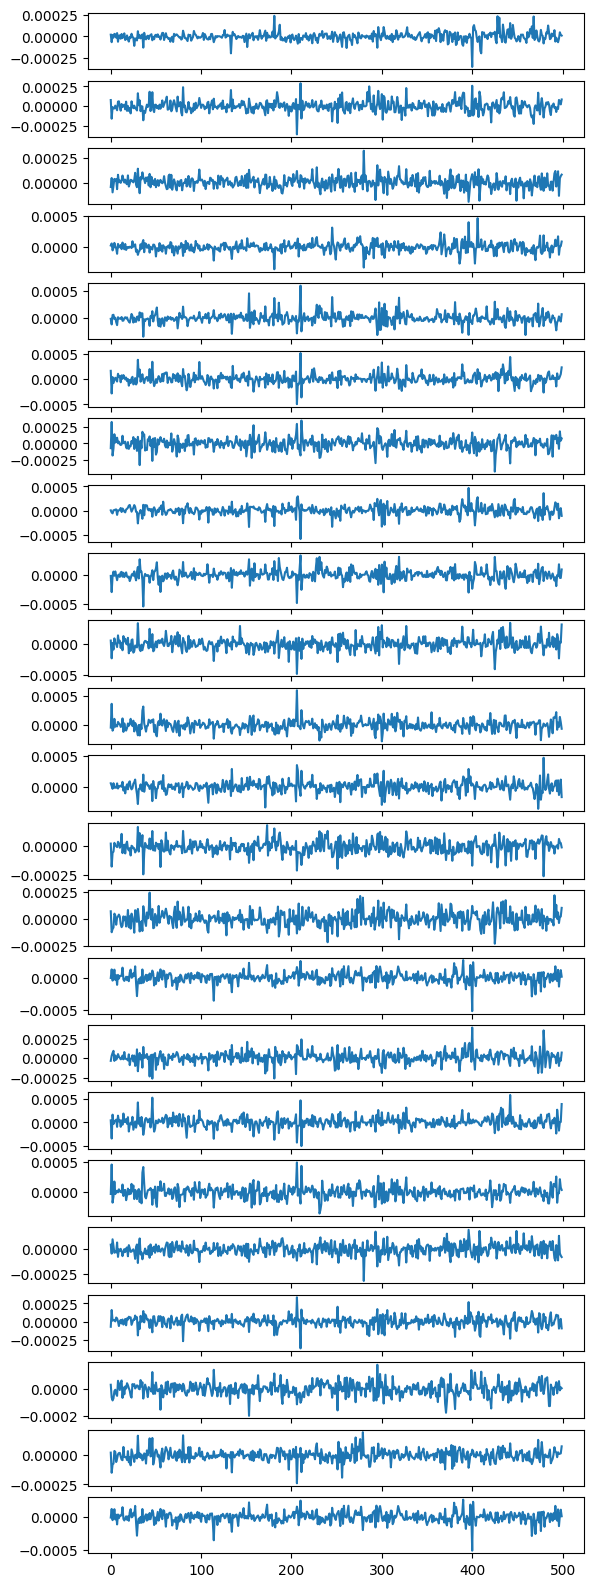

In [28]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(23, 1)
figure.set_figheight(20)
for i in range(23):
    time = np.array([k / 256 for k in range(step)], dtype = np.float32) * 256
    axis[i].plot(time, signal[i][np.array(time * 256, dtype = np.int32)])
plt.show()

In [29]:
labels = [0,0,0,0,1,1,1,1] * 100

In [30]:
def preprocess_data_infer(file):
    raw = mne.io.read_raw_edf(file, preload=True)

    if len(raw.ch_names) != 23:
        return None, None   
    
    dropped_channels = ['P7-T7', 'T7-FT9','FT9-FT10', 'FT10-T8', 'T8-P8-1']
    raw.drop_channels(dropped_channels)
    raw.rename_channels({'T8-P8-0': 'T8-P8'})
    raw.filter(l_freq=5.0, h_freq=50.0)

    if len(raw.ch_names) != 18:
        return None, None
    
    epoch = process_signal_infer(raw)
    #epoch, labels = subsampling_and_mix(epoch, labels)
    #features, f_labels = split_and_extract_features(epoch, labels)
    epoch_features = []
    for i, trial in enumerate(epoch): 
        csp_trial = apply_csp_trial(trial, W)
        features = extract_features_trial(csp_trial)
        epoch_features.append(features[np.newaxis, :, np.newaxis])
    epoch_features = np.concatenate(epoch_features)
    epoch_features = self_prod(epoch_features)
    return epoch_features

In [31]:
dummy_input = preprocess_data_infer(sample_raw_file)

(2652, 18, 1)


In [32]:
print(dummy_input.shape)

(2652, 18, 18)


In [33]:
model_GRU.eval()
with torch.no_grad():
    ans = []
    for i in range(700):
        input = torch.tensor(dummy_input[i: i + 20, :, :]);
        res = model_GRU(input.unsqueeze(0).to(torch.float).to('cuda'))
        ans.append(res);
    ans = torch.cat(list(map(lambda x: x.detach().cpu(), ans)))
    #print(ans)
    softmax = nn.Softmax()
    logits = softmax(ans)
    logits = torch.argmax(ans, dim=1)
logits

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
labels = [0 for i in range(20)] + logits.tolist()
labels = [val for val in labels for i in range(5)]
#print(labels)

In [35]:
step = 500

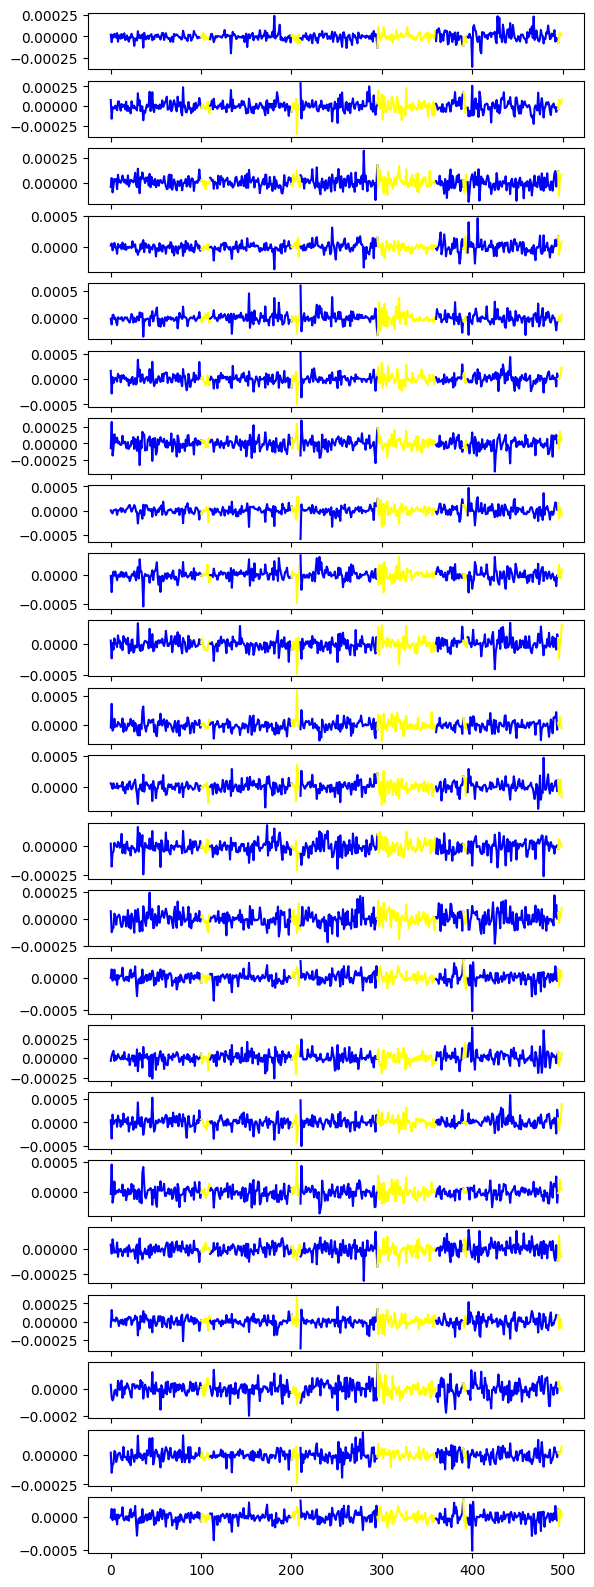

In [36]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(23, 1)
figure.set_figheight(20)
for i in range(23):
    time = np.array([k / 256 for k in range(step)], dtype = np.float32) * 256
    st = 0
    for j in range(step):
        if j != 0:
            if labels[j] != labels[j - 1]:
                axis[i].plot(time[st:j + 1], signal[i][np.array(time * 256, dtype = np.int32)][st:j + 1], c = 'yellow' if labels[j - 1] else 'blue')
                st = j
    j = step
    axis[i].plot(time[st:j + 1], signal[i][np.array(time * 256, dtype = np.int32)][st:j + 1], c = 'yellow' if labels[j - 1] else 'blue')
    st = j
plt.show()